In [13]:
# Advanced Statistical Machine Learning & Pattern Recognition - CO495
# skeleton for CW1
# Written for Python 3.

In [14]:
import h5py
from scipy.io import savemat
import numpy as np
import csv
import matplotlib.pyplot as plt

try:
    %matplotlib inline
except NameError:
    # this is a terminal, that's fine.
    pass

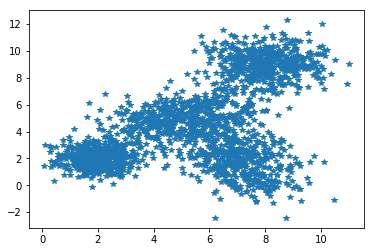

In [15]:
import numpy as np
from scipy import cluster
# load the file.
f = h5py.File('X.mat')
f.keys()

X = f.get('X').value
N = X.shape[1]
# print(X.shape)
X_T = np.transpose(X)
init_centroid = np.array([[2,2],[5,5],[7,2],[8,9]], np.float32)
centroids, labels = cluster.vq.kmeans2(X_T,k=4, iter=100, thresh=1e-05, minit='random', missing='warn', check_finite=True)
# print(centroids)
# print(labels)
clusters = [0,0,0,0]
for i in range(N):
    clusters[labels[i]] += 1
    
# print(clusters)
# print(clusters[0]/float(N))
    
for l in range(4):
    cluster_samples = []
    for k in range(N):
        if labels[k] == l:
            cluster_samples.append(X_T[k])
    c = np.cov(np.transpose(np.array(cluster_samples)))
#     print(c)
#     print(np.divide(clusters[l],float(N)))
# cluster_samples2 = np.array(cluster_samples)
# print(cluster_samples2)

# for l in range(4):
#     c = np.cov(np.transpose(cluster_samples2[l]))
#     print(c)
# print(len(X[0,:]))
# optionally visualise the X matrix.
try:
    plt.plot(X[0, :], X[1, :], '*')
except:
    pass

# EM Init

In [16]:
from scipy import cluster
import numpy

def EMInit(X,K):
#     (X, K) 
    X_T = np.transpose(X)
    centroids, labels = cluster.vq.kmeans2(X_T, K, iter=50, thresh=1e-05, minit='random', missing='warn', check_finite=True)
#     print(centroids)
    clusters = [0,0,0,0]
    for i in range(N):
        clusters[labels[i]] += 1
    
#     print(clusters)
#     print(clusters[0]/float(N))
    c = np.zeros((4,2,2))
    mc = [0.0,0.0,0.0,0.0]
    for l in range(4):
        cluster_samples = []
        for k in range(N):
            if labels[k] == l:
                cluster_samples.append(X_T[k])
        c[l] = np.cov(np.transpose(np.array(cluster_samples)))
#         print(c)
        mc[l]=np.divide(clusters[l],float(N))
    params = {}
    for i in range(1, K + 1):
        nn = 'means_{}'.format(i)
        params[nn] = centroids[i-1]
        nn = 'covars_{}'.format(i)
        params[nn] = c[l-1]
        nn = 'mixCoeff_{}'.format(i)
        params[nn] = mc[l-1]
#     print("init: ", params)
    return params

In [17]:
from scipy import cluster
import numpy

def EMInit_Random(X,K):
    return random_params_generator(K)

# EM E step

In [18]:
from scipy import stats
import numpy as np

def is_pos_semi_def(x):
    return np.all(np.linalg.eigvals(x) >= 0)

def EMEStep(X, K, params):
    # X, K, params
    # X is (2, 2000)
    # Z is N x k = 2000 x k
#     print(len(X[0,:]))
#     print(C)
    z = numpy.zeros((len(X[0,:]), K))
#     print("z shape:", z.shape)
    for n in range(len(X[0,:])):
        for k in range(K):
            pi_k = params['mixCoeff_{}'.format(k+1)]
            mu_k = params['means_{}'.format(k+1)]
            cov_k = params['covars_{}'.format(k+1)]
#             if not is_pos_semi_def(cov_k):
#                 cov_k_positivesemi = numpy.dot(cov_k, cov_k.transpose())
#             else:
#                 cov_k_positivesemi = cov_k
#             if np.linalg.cond(cov_k) < 1/sys.float_info.epsilon:
#                 print("fuck1!!!!")
#                 print(cov_k)
#             print("cov: ", cov_k)
            N_nk = stats.multivariate_normal.pdf(X[:, n], mean=mu_k, cov=cov_k)
            numerator = np.multiply(pi_k,N_nk) # 1x1
#             print("numerator shape: ", numerator.shape)
            z[n, k] = numerator
        denominator = z.sum(axis=1)[n] # 1x1
#         print("denominator shape: ", denominator.shape)
        n_row = np.divide(z[n,:], denominator)
#         print("n_row shape: ", n_row.shape) # 1xk
        z[n,:] = n_row
#     print('Please fill in the function and delete the comment!')
    return z

# EM M step

In [19]:
def EMMStep(X, K, E):
#     (X, K, resp)
    N = X.shape[1]
    D = X.shape[0]
#     print("D = ", D)
#     print("N = ", N)
#     print("K = ", K)
    E_sum_row = E.sum(axis=0) # k x 1
#     E_sum_row = numpy.reshape(E_sum_row, (1,K))
#     print("E_sum_row = ", E_sum_row.shape)
    pi = np.divide(E_sum_row, N) # k x 1
#     print("pi = ", pi)
#     print("pi.shape: ", pi.shape)
# E_sum_row =  (1, 4)
# pi =  (1, 4)
# mu_k shape:  (2,)
# diff.shape:  (2,)
# diff.shape:  (2, 1)
# diff_sq.shape:  (2, 2)
# numerator.shape:  (2, 2)
    mu = numpy.zeros((K, D)) # K x D
    E_T = numpy.transpose(E) # K x N
    X_T = numpy.transpose(X) # N x D
    mu = numpy.dot(E_T, X_T) # K x D
    cov = numpy.zeros((K, D, D)) # K x D x D
    for k in range(K):
        mu[k, :] = np.divide(mu[k, :], E_sum_row[k])
#         print("mu[k, :] ", mu[k, :])
        numerator = numpy.zeros((D, D)) # D x D
        for n in range(N):
            mu_k = mu[k, :] # 1 x D 
#             print("mu_k shape: ", mu_k.shape)
            diff = numpy.subtract(np.transpose(X[:, n]), mu_k) # 1 x D 
#             print("diff: ", diff)
            diff = numpy.reshape(diff, (2,1))
            diff_sq = numpy.dot(diff, numpy.transpose(diff)) # D x D
#             diff = numpy.reshape(mu_k, (1, D))
#             print("diff: ", diff)
#             diff_sq = numpy.dot(numpy.transpose(diff),diff) # D x D
#             print("diff_sq: ", diff_sq)
            numerator = numerator + numpy.multiply(E[n, k],diff_sq)
#             print("numerator.shape: ", numerator.shape)
        denominator = E_sum_row[k]
#         print("numerator: ", numerator)
#         print("denominator: ", denominator)
        covv = np.divide(numerator, denominator)
#         print("covv: ", covv)
        cov[k, :, :] = covv
#         print("cov_k: ", cov[k, :, :])
#     print("mu", mu)
    params = {}
    for i in range(1, K + 1):
        nn = 'means_{}'.format(i)
        params[nn] = mu[i-1]
        nn = 'covars_{}'.format(i)
        params[nn] = cov[i-1]
        nn = 'mixCoeff_{}'.format(i)
        params[nn] = np.array([pi[i-1]])
    return params

# GMM Demo

In [20]:
import numpy as py

# aux functions
def random_params_generator(K):
    params = {}
    for i in range(1, K + 1):
        nn = 'means_{}'.format(i)
        params[nn] = np.random.rand(2)
        nn = 'covars_{}'.format(i)
        x = np.random.rand(2, 2)
        params[nn] = np.dot(np.transpose(x), x)
        nn = 'mixCoeff_{}'.format(i)
        params[nn] = np.random.rand(1)
    return params


def convert_params_to_row(params, K):
    # accepts the params dict and converts it to a row to be exported.
    # The covars are flattened per row.
    row = []
    for var in ['means', 'covars', 'mixCoeff']:
        for i in range(1, K + 1):
            elems = params['{}_{}'.format(var, i)].flatten()
            row += [str(el) for el in elems]
    return row

# pp = random_params_generator(4)
# p = pp['means_1']
# print(p)

In [21]:
def GMMDemo(X, K=4):
    # accepts a 2 dimensional matrix X with the observed 
    # data and the K, which represents the number of clusters.
    # Please do not modify it!
    #
    # initialise the parameters
    params = EMInit(X, K)
#     params = EMInit_Random(X, K) 
    # params should be a dict() with the following format:
    # params['means_[i]'] -> [2x1 float] (i \in [1, K])
    # params['covars_[i]'] -> [2x2 float] (i \in [1, K])
    # params['mixCoeff_[i]'] -> [1x1 float] (i \in [1, K])
    print("init ", params)
    # EM algorithm
    # do not change the iterations --- keep them fixed.
    for i in range(10):
        # E step
        resp = EMEStep(X, K, params); # compute responsibilities, i.e., every \gamma(z_{n,k})
        rspArray = np.array(resp)
        clusterIndex = np.argmax(rspArray, axis=1)
        data = X
        plt.figure(i)
        plt.scatter(data[0,:], data[1, :], c=clusterIndex)
        plt.show()
#         print("iter ", i, "  resp.shape: ", resp.shape)
        
        # M step
        params = EMMStep(X, K, resp) # update the values for the parameters
        print(params)
#         print("iter ", i,"  ", params)
    # comment out the line below once you have implemented 
    # the init code!
    # params = random_params_generator(K)
    # save the final values for the parameters
    savemat('params.mat', {'params' : params})
    # export in csv.
    row = convert_params_to_row(params, K)
    with open('params.csv', 'w', encoding='utf-8-sig') as fn:
        writer = csv.writer(fn)
        writer.writerow(row)

init  {'mixCoeff_2': 0.27100000000000002, 'means_3': array([ 2.05777579,  2.1137154 ]), 'covars_4': array([[ 0.56781963,  0.06749148],
       [ 0.06749148,  0.61882552]]), 'means_4': array([ 7.96714603,  9.02735559]), 'mixCoeff_3': 0.27100000000000002, 'mixCoeff_1': 0.27100000000000002, 'covars_1': array([[ 0.56781963,  0.06749148],
       [ 0.06749148,  0.61882552]]), 'means_1': array([ 5.20891438,  4.99047893]), 'covars_2': array([[ 0.56781963,  0.06749148],
       [ 0.06749148,  0.61882552]]), 'covars_3': array([[ 0.56781963,  0.06749148],
       [ 0.06749148,  0.61882552]]), 'mixCoeff_4': 0.27100000000000002, 'means_2': array([ 7.19484019,  1.62814244])}


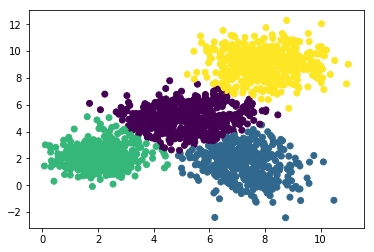

{'mixCoeff_2': array([ 0.21766945]), 'means_3': array([ 2.06350398,  2.13220409]), 'covars_4': array([[ 1.02015918,  0.00251379],
       [ 0.00251379,  1.05460294]]), 'means_4': array([ 7.96957959,  9.02793274]), 'mixCoeff_3': array([ 0.27233765]), 'mixCoeff_1': array([ 0.25445712]), 'covars_1': array([[ 1.39307816,  0.11063488],
       [ 0.11063488,  0.86811161]]), 'means_1': array([ 5.21735468,  4.98500825]), 'covars_2': array([[ 0.89709674, -0.24147487],
       [-0.24147487,  1.4197377 ]]), 'covars_3': array([[ 0.5748401 ,  0.08697385],
       [ 0.08697385,  0.66467222]]), 'mixCoeff_4': array([ 0.25553578]), 'means_2': array([ 7.19865094,  1.63963353])}


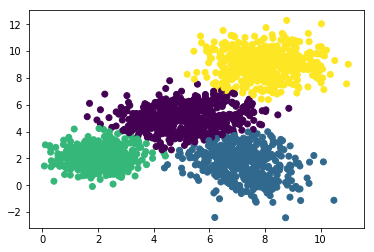

{'mixCoeff_2': array([ 0.22373634]), 'means_3': array([ 2.03563358,  2.08004488]), 'covars_4': array([[ 1.03502079,  0.01589893],
       [ 0.01589893,  1.04558786]]), 'means_4': array([ 7.96414755,  9.03373389]), 'mixCoeff_3': array([ 0.26425489]), 'mixCoeff_1': array([ 0.25720429]), 'covars_1': array([[ 1.6127569 ,  0.16842756],
       [ 0.16842756,  0.90168477]]), 'means_1': array([ 5.16284097,  4.97979705]), 'covars_2': array([[ 0.96750019, -0.33652778],
       [-0.33652778,  1.5378999 ]]), 'covars_3': array([[ 0.54496581,  0.06165908],
       [ 0.06165908,  0.56105583]]), 'mixCoeff_4': array([ 0.25480449]), 'means_2': array([ 7.14175681,  1.70149001])}


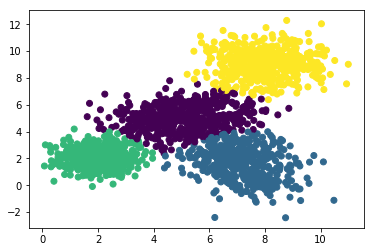

{'mixCoeff_2': array([ 0.22823159]), 'means_3': array([ 2.0157751 ,  2.04922074]), 'covars_4': array([[ 1.03695021,  0.01482164],
       [ 0.01482164,  1.03148281]]), 'means_4': array([ 7.96486737,  9.04078155]), 'mixCoeff_3': array([ 0.25919286]), 'mixCoeff_1': array([ 0.25855759]), 'covars_1': array([[ 1.70962041,  0.23561485],
       [ 0.23561485,  0.91430661]]), 'means_1': array([ 5.1206075 ,  4.98039231]), 'covars_2': array([[ 1.00121102, -0.38356445],
       [-0.38356445,  1.60511122]]), 'covars_3': array([[ 0.52252654,  0.0367539 ],
       [ 0.0367539 ,  0.51138112]]), 'mixCoeff_4': array([ 0.25401796]), 'means_2': array([ 7.11267096,  1.74220308])}


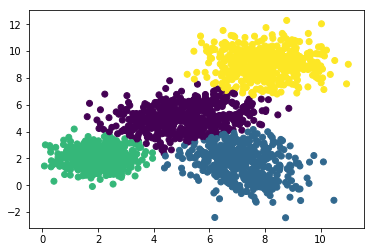

{'mixCoeff_2': array([ 0.23188248]), 'means_3': array([ 2.00386827,  2.0320707 ]), 'covars_4': array([[ 1.03714716,  0.01120702],
       [ 0.01120702,  1.01923973]]), 'means_4': array([ 7.96664682,  9.04739095]), 'mixCoeff_3': array([ 0.25607806]), 'mixCoeff_1': array([ 0.25879165]), 'covars_1': array([[ 1.76319516,  0.29683714],
       [ 0.29683714,  0.92809197]]), 'means_1': array([ 5.08959113,  4.98449993]), 'covars_2': array([[ 1.01944639, -0.41126025],
       [-0.41126025,  1.65608503]]), 'covars_3': array([[ 0.50919736,  0.02288186],
       [ 0.02288186,  0.48770849]]), 'mixCoeff_4': array([ 0.25324781]), 'means_2': array([ 7.09486863,  1.77443585])}


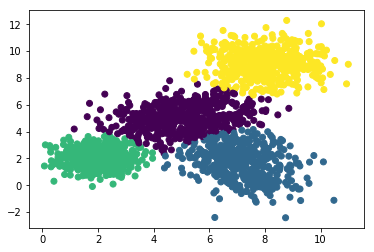

{'mixCoeff_2': array([ 0.2348738]), 'means_3': array([ 1.99703115,  2.02235014]), 'covars_4': array([[ 1.03670143,  0.00720635],
       [ 0.00720635,  1.00862616]]), 'means_4': array([ 7.96865663,  9.05345245]), 'mixCoeff_3': array([ 0.2541487]), 'mixCoeff_1': array([ 0.25846259]), 'covars_1': array([[ 1.79813533,  0.34740858],
       [ 0.34740858,  0.94261528]]), 'means_1': array([ 5.06758083,  4.99049757]), 'covars_2': array([[ 1.030329  , -0.43053068],
       [-0.43053068,  1.69920197]]), 'covars_3': array([[ 0.50178991,  0.01560766],
       [ 0.01560766,  0.47579241]]), 'mixCoeff_4': array([ 0.25251491]), 'means_2': array([ 7.08241802,  1.80114569])}


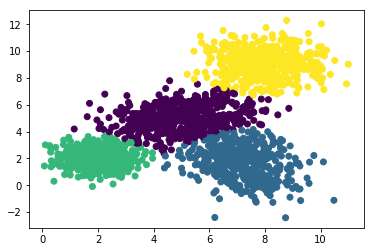

{'mixCoeff_2': array([ 0.23733307]), 'means_3': array([ 1.99306283,  2.01651278]), 'covars_4': array([[ 1.03599545,  0.00343391],
       [ 0.00343391,  0.99954402]]), 'means_4': array([ 7.97059256,  9.05881929]), 'mixCoeff_3': array([ 0.25291641]), 'mixCoeff_1': array([ 0.25789968]), 'covars_1': array([[ 1.82355953,  0.38772997],
       [ 0.38772997,  0.956071  ]]), 'means_1': array([ 5.05198619,  4.99707865]), 'covars_2': array([[ 1.03774706, -0.44570073],
       [-0.44570073,  1.73658706]]), 'covars_3': array([[ 0.49764762,  0.01161657],
       [ 0.01161657,  0.46923591]]), 'mixCoeff_4': array([ 0.25185084]), 'means_2': array([ 7.07283496,  1.82352521])}


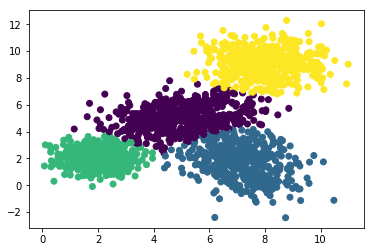

{'mixCoeff_2': array([ 0.23936693]), 'means_3': array([ 1.99067712,  2.01277731]), 'covars_4': array([[  1.03524801e+00,   1.45418814e-04],
       [  1.45418814e-04,   9.91955102e-01]]), 'means_4': array([ 7.97230543,  9.06340065]), 'mixCoeff_3': array([ 0.25209609]), 'mixCoeff_1': array([ 0.25726141]), 'covars_1': array([[ 1.84325598,  0.41961367],
       [ 0.41961367,  0.96767294]]), 'means_1': array([ 5.04072375,  5.00344316]), 'covars_2': array([[ 1.04351572, -0.45842348],
       [-0.45842348,  1.76892064]]), 'covars_3': array([[ 0.49523757,  0.00928411],
       [ 0.00928411,  0.46528389]]), 'mixCoeff_4': array([ 0.25127557]), 'means_2': array([ 7.06501419,  1.84232194])}


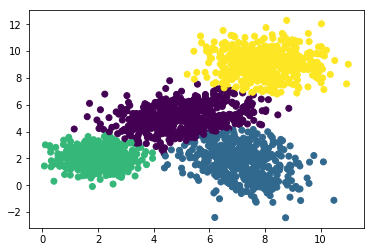

{'mixCoeff_2': array([ 0.2410591]), 'means_3': array([ 1.98918107,  2.01025166]), 'covars_4': array([[ 1.03456773, -0.00259117],
       [-0.00259117,  0.98574493]]), 'means_4': array([ 7.97374577,  9.06720593]), 'mixCoeff_3': array([ 0.25152731]), 'mixCoeff_1': array([ 0.25662076]), 'covars_1': array([[ 1.85900765,  0.44488176],
       [ 0.44488176,  0.97730438]]), 'means_1': array([ 5.03236618,  5.00921106]), 'covars_2': array([[ 1.04839812, -0.46935911],
       [-0.46935911,  1.79669155]]), 'covars_3': array([[ 0.49376257,  0.0078397 ],
       [ 0.0078397 ,  0.46271538]]), 'mixCoeff_4': array([ 0.25079283]), 'means_2': array([ 7.05843807,  1.85812224])}


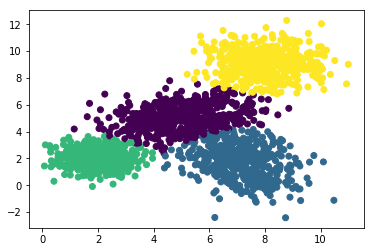

{'mixCoeff_2': array([ 0.24247406]), 'means_3': array([ 1.98820508,  2.00846808]), 'covars_4': array([[ 1.03399347, -0.00480785],
       [-0.00480785,  0.98073425]]), 'means_4': array([ 7.97492109,  9.07031109]), 'mixCoeff_3': array([ 0.2511191]), 'mixCoeff_1': array([ 0.25601097]), 'covars_1': array([[ 1.87179466,  0.46501433],
       [ 0.46501433,  0.98513263]]), 'means_1': array([ 5.02599077,  5.01425868]), 'covars_2': array([[ 1.05268825, -0.47882271],
       [-0.47882271,  1.82041508]]), 'covars_3': array([[ 0.49281462,  0.00690146],
       [ 0.00690146,  0.46094751]]), 'mixCoeff_4': array([ 0.25039587]), 'means_2': array([ 7.05283549,  1.87141623])}


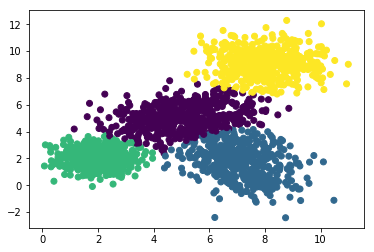

{'mixCoeff_2': array([ 0.24366193]), 'means_3': array([ 1.9875473 ,  2.00716632]), 'covars_4': array([[ 1.03352822, -0.00657692],
       [-0.00657692,  0.97672415]]), 'means_4': array([ 7.97586389,  9.07281851]), 'mixCoeff_3': array([ 0.25081814]), 'mixCoeff_1': array([ 0.25544652]), 'covars_1': array([[ 1.88224485,  0.4811455 ],
       [ 0.4811455 ,  0.99141455]]), 'means_1': array([ 5.02100764,  5.01859301]), 'covars_2': array([[ 1.05649835, -0.48701326],
       [-0.48701326,  1.84061603]]), 'covars_3': array([[ 0.49218004,  0.0062688 ],
       [ 0.0062688 ,  0.45967799]]), 'mixCoeff_4': array([ 0.2500734]), 'means_2': array([ 7.04803855,  1.88261567])}


In [22]:
GMMDemo(X)